### **Importing necessary dependencies and libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
import nltk
from gensim.models.keyedvectors import KeyedVectors
import operator
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import TFBertModel
from transformers import AutoTokenizer
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import logging
logging.disable(logging.WARNING)
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras.layers import *

# **Dataset**

In [ ]:
# Reading the dataset and setting 'id' as the index
dataset = pd.read_csv("TextualDisasterSocialMediaDataset.csv", index_col='id')

# Displaying the dataframe
dataset

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


# **Data Preprocessing**

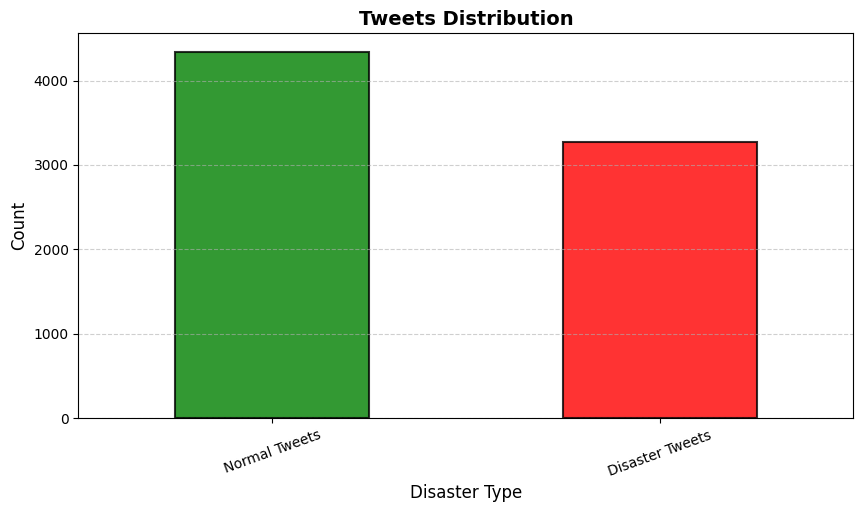

In [ ]:
# Counting and renaming the target values
target = dataset['target'].value_counts().rename({0: 'Normal Tweets', 1: 'Disaster Tweets'})

# Creating a bar chart
plt.figure(figsize=(10, 5))
target.plot.bar(color=['green', 'red'], alpha=0.8, edgecolor='black', linewidth=1.5)
plt.title('Tweets Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Disaster Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=20, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

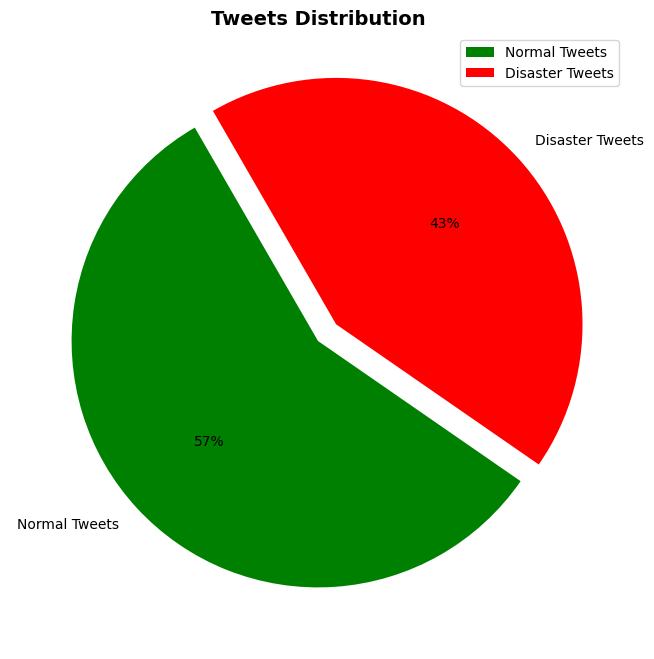

In [ ]:
# Creating a pie chart with integer percentages
plt.figure(figsize=(8, 8))
target.plot.pie(explode=[0, 0.1], autopct=lambda p: f'{int(round(p))}%', startangle=120, colors=['green', 'red'])
plt.title('Tweets Distribution', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.legend(prop={'size': 10})
plt.show()

# **Extracting Key Features**

### **Keyword**

In [ ]:
# Counting occurrences of each keyword, including NaN values
keywords = dataset['keyword'].value_counts(dropna=False)

# Displaying the keyword counts
keywords

keyword
NaN                      61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 222, dtype: int64

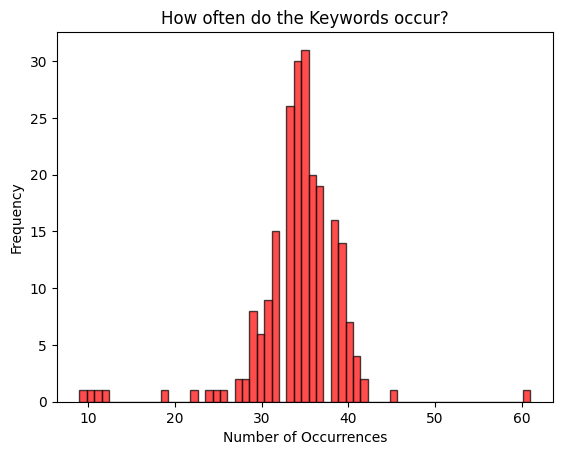

In [ ]:
# Creating a figure and axis for the histogram
f, ax = plt.subplots()

# Plotting the histogram of keyword occurrences with red color and added edge effects
keywords.plot.hist(ax=ax, bins=61, color='red', edgecolor='black', alpha=0.7)

# Setting the title and labels for the histogram
ax.set_title('How often do the Keywords occur?')
ax.set_xlabel('Number of Occurrences')
ax.set_ylabel('Frequency')

# Displaying the plot
plt.show()

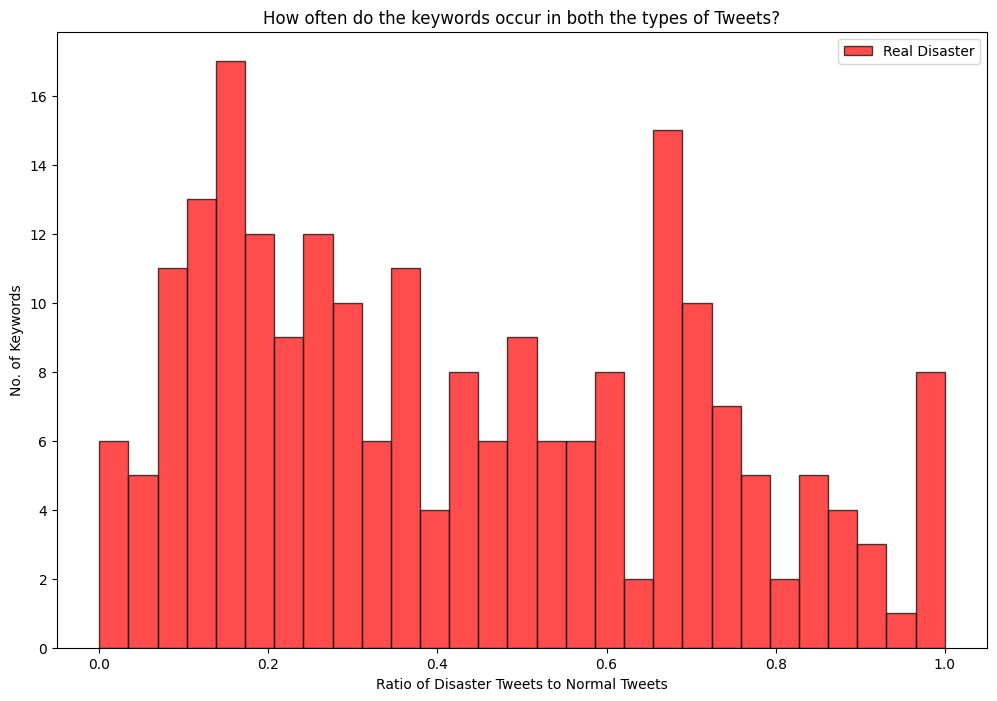

In [ ]:
# Grouping the dataset by 'keyword' and counting occurrences of each target category
grouping_keywords_by_target = dataset.groupby('keyword')['target'].value_counts()

# Lists to store the proportion of unreal and real disaster posts for each keyword
sharing_normal_tweets, sharing_disasters_tweets = [], []

# Iterating over unique keywords to compute proportions
for keyword in dataset['keyword'].dropna().unique():
    keyword_value = grouping_keywords_by_target[keyword]
    sum_count = sum(keyword_value)

    # Calculating the proportion of real and unreal disaster posts
    if 0 in keyword_value:
        sharing_normal_tweets.append(keyword_value[0] / sum_count)
        sharing_disasters_tweets.append(1 - keyword_value[0] / sum_count)
    else:
        sharing_normal_tweets.append(0)
        sharing_disasters_tweets.append(1)

# Defining bins for the histogram
bins = np.linspace(0, 1, 30)

# Creating a figure and axis for the histogram
f, ax = plt.subplots(figsize=(12, 8))

# Plotting the histogram for the share of real disaster posts with added effects
plt.hist(sharing_disasters_tweets, bins, color='red', edgecolor='black', alpha=0.7, label='Real Disaster')

# Adding legend, title, and labels
plt.legend(loc='upper right')
ax.set_title('How often do the keywords occur in both the types of Tweets?')
ax.set_xlabel('Ratio of Disaster Tweets to Normal Tweets')
ax.set_ylabel('No. of Keywords')

# Displaying the plot
plt.show()

### Location

In [ ]:
# Counting occurrences of each location, including null values
places = dataset['location'].value_counts(dropna=False)

# Displaying the location counts
places

location
NaN                             2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: count, Length: 3342, dtype: int64

In [ ]:
# Locations that appear at least 5 times
list(places.loc[lambda x: x >= 5].index)

[nan,
 'USA',
 'New York',
 'United States',
 'London',
 'Canada',
 'Nigeria',
 'UK',
 'Los Angeles, CA',
 'India',
 'Mumbai',
 'Washington, DC',
 'Kenya',
 'Worldwide',
 'Chicago, IL',
 'Australia',
 'California',
 'New York, NY',
 'Everywhere',
 'California, USA',
 'San Francisco',
 'United Kingdom',
 'Florida',
 'Indonesia',
 'Washington, D.C.',
 'Los Angeles',
 'NYC',
 'Ireland',
 'Toronto',
 'Earth',
 'Seattle',
 'Chicago',
 'San Francisco, CA',
 'London, England',
 'Atlanta, GA',
 'ss',
 'Sacramento, CA',
 'New York City',
 'Texas',
 'London, UK',
 'San Diego, CA',
 'Dallas, TX',
 '304',
 'Nashville, TN',
 'Denver, Colorado',
 'World',
 'US',
 'Manchester',
 'Scotland',
 'Houston, TX',
 'South Africa',
 'Sydney',
 'Denver, CO',
 'Memphis, TN',
 'Austin, TX',
 'Pennsylvania, USA',
 'Tennessee',
 'worldwide',
 'Seattle, WA',
 'Morioh, Japan',
 'Pedophile hunting ground',
 'Orlando, FL',
 'Portland, OR',
 'Planet Earth',
 'California, United States',
 'Calgary, Alberta',
 'Singapore

In [ ]:
# Locations that appear only once
list(places.loc[lambda x : x == 1].index)[:100]

['Rocketing through the galaxy',
 'Leeds',
 'on to the next adventure',
 'EspaÌ±a, Spain',
 'Aurora, IL',
 'Miami Beach, Fl',
 'US, PA',
 'Fukuoka, Japan',
 'h+l',
 'sÌ£o luis',
 'Jonesboro, AR MO, IOWA USA',
 'SoCal',
 'New York City, NY',
 'in my own personal hell (:',
 'Huntsville AL',
 'Oneonta, NY/ Staten Island, NY',
 'lia\x89Û¢dani\x89Û¢laura',
 'Stratford, CT',
 'kano',
 'Miami?Gainesville',
 'Suburban Detroit, Michigan',
 'East Lansing, MI',
 'Aix-en-Provence/Utrecht',
 'Fukushima city Fukushima.pref',
 'Dammam- KSA',
 'Under Santa Barbara Skies',
 '#goingdownthetoilet Illinois',
 'Sacramento, California',
 'Corpus Christi',
 'Derbyshire, United Kingdom',
 'VCU',
 'Dhaka, Bangladsh',
 'McLean, VA',
 'South Florida',
 'Guatemala',
 'Ashford, Kent, United Kingdom',
 'Hammersmith, London',
 'Marbella. Spain',
 'Positive 852',
 'Kansas City, Mo.',
 'Austin TX',
 'Wahpeton, ND',
 'Littleton, CO',
 "don't run",
 '?? ?+254? ? \\??å¡_??å¡_???å¡_?/??',
 'Leitchfield Kentucky',
 'Honolu

In [ ]:
# Defining a function to clean location names
def location_cleaning(text: str):
    # Removing all non-alphabetic characters and replacing them with spaces
    result = re.sub(r'[^A-Za-z\s]', ' ', text)

    # Removing single-character words
    result = ' '.join([w for w in result.split() if len(w) > 1])

    # Replacing multiple spaces with a single space
    result = re.sub(' +', ' ', result)

    # Stripping leading/trailing spaces and converting text to lowercase
    result = result.strip().lower()

    # Replacing country names with their abbreviations
    result = re.sub(r'(^|\s)(us|united states)($|\s)', ' usa ', result)
    result = re.sub(r'(^|\s)(united kingdom|england)($|\s)', ' uk ', result)

    return result.strip().lower()

# Applying the location cleaning function to the dataset
dataset['location'] = dataset.apply(lambda row: pd.NA if pd.isna(row['location']) else location_cleaning(row['location']), axis=1)

# Counting occurrences of each unique location, including NaN values
places = dataset['location'].value_counts(dropna=False)

# Displaying the location counts
places

location
<NA>              2533
usa                166
                   146
new york            78
london              51
                  ... 
beirut lebanon       1
el paso texas        1
qosqo                1
lubbock tx           1
lincoln              1
Name: count, Length: 2908, dtype: int64

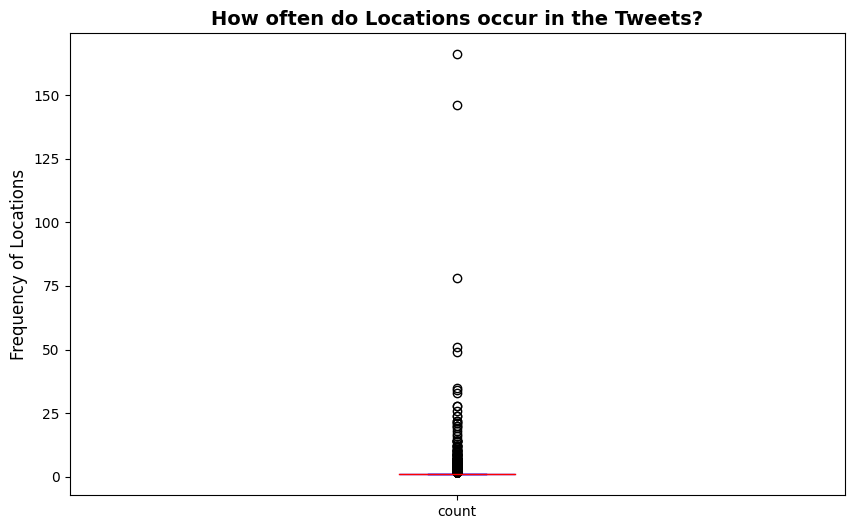

In [ ]:
# Creating a figure with one subplot for the box plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the box plot for location frequencies
dataset['location'].value_counts().plot.box(ax=ax, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'),
                                       whiskerprops=dict(color='blue'), capprops=dict(color='blue'),
                                       medianprops=dict(color='red'))
ax.set_title('How often do Locations occur in the Tweets?', fontsize=14, fontweight='bold')
ax.set_ylabel('Frequency of Locations', fontsize=12)

# Displaying the box plot
plt.show()

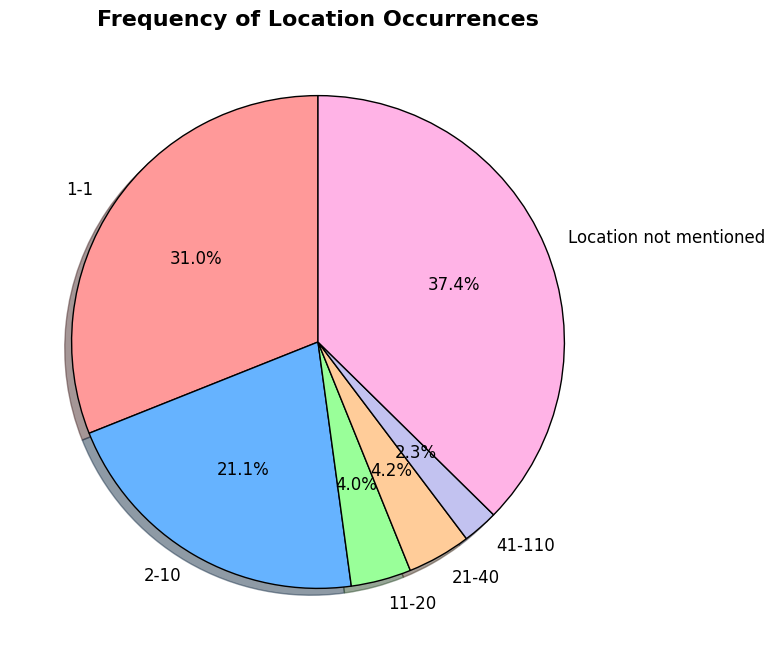

In [ ]:
# Pie chart
fig, ax = plt.subplots(figsize=(12, 8))

# Defining bins for categorising places
bins = [0, 1, 10, 20, 40, 110, 2533]

# Creating a DataFrame for location counts and categorising into bins
places_count = pd.DataFrame(places)
places_count['bins'] = pd.cut(places, bins=bins, labels=['Location not mentioned' if bins[i+1] == 2533 else f'{bins[i] + 1}-{bins[i+1]}' for i in range(len(bins) - 1)])

# Plotting the pie chart for location occurrences
places_count.groupby('bins').sum()['count'].plot.pie(autopct='%1.1f%%', ax=ax, shadow=True, startangle=90,
                                                        colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6'],
                                                        wedgeprops={'edgecolor': 'black', 'linewidth': 1},
                                                        textprops={'fontsize': 12})
ax.set_title('Frequency of Location Occurrences', fontsize=16, fontweight='bold')
ax.set_ylabel('')

# Displaying the pie chart
plt.show()

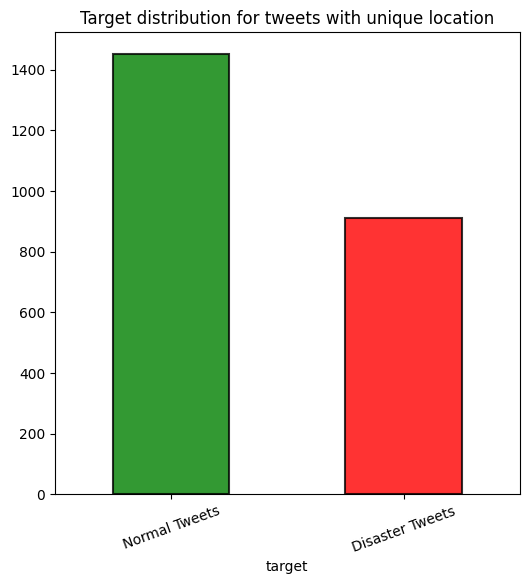

In [ ]:
# Tweets with unique places
plt.figure(figsize=(6, 6))
dataset_unique_places = dataset[dataset['location'].isin(dataset['location'].value_counts()[dataset['location'].value_counts() == 1].index)]
places_unique = dataset_unique_places['target'].value_counts().rename({0: 'Normal Tweets', 1: 'Disaster Tweets'})
places_unique.plot.bar(color=['green', 'red'], rot=20, alpha=0.8, edgecolor='black', linewidth=1.5)
plt.title('Target distribution for tweets with unique location')
plt.show()

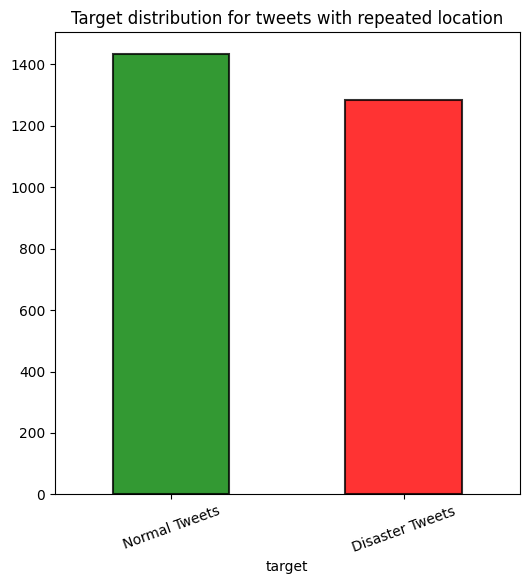

In [ ]:
# Tweets with repeated places
plt.figure(figsize=(6, 6))
dataset_repeated_places = dataset[dataset['location'].isin(dataset['location'].value_counts()[dataset['location'].value_counts() > 1].index)]
repeated_places = dataset_repeated_places['target'].value_counts().rename({0: 'Normal Tweets', 1: 'Disaster Tweets'})
repeated_places.plot.bar(color=['green', 'red'], rot=20, alpha=0.8, edgecolor='black', linewidth=1.5)
plt.title('Target distribution for tweets with repeated location')
plt.show()

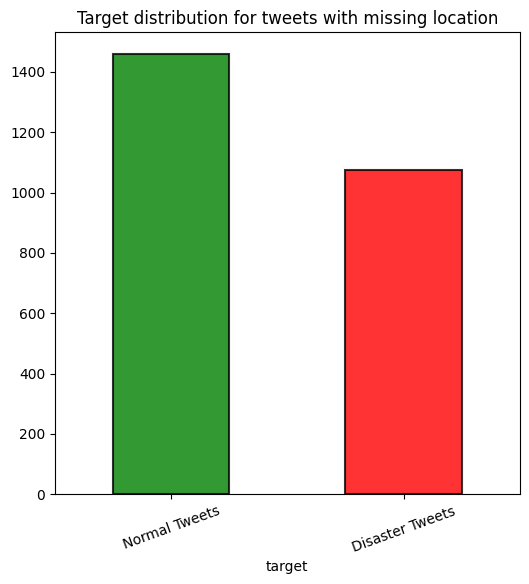

In [ ]:
# Tweets with missing location
plt.figure(figsize=(6, 6))
missing_place = dataset[dataset['location'].isna()]['target'].value_counts().rename({0: 'Normal Tweets', 1: 'Disaster Tweets'})
missing_place.plot.bar(color=['green', 'red'], rot=20, alpha=0.8, edgecolor='black', linewidth=1.5)
plt.title('Target distribution for tweets with missing location')
plt.show()

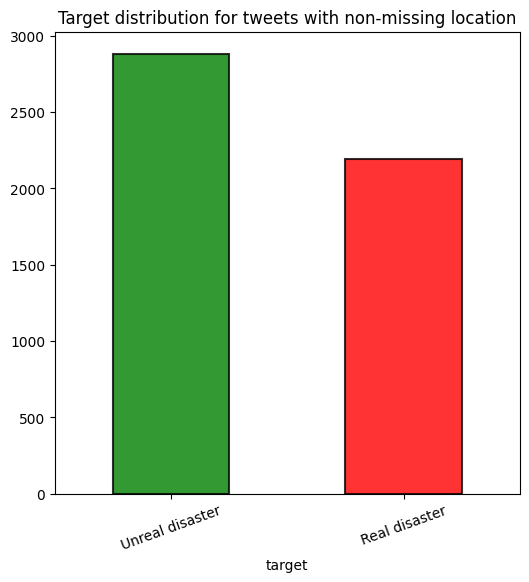

In [ ]:
# Tweets with non-missing location
plt.figure(figsize=(6, 6))
having_place.plot.bar(color=['green', 'red'], rot=20, alpha=0.8, edgecolor='black', linewidth=1.5)
having_place = dataset[dataset['location'].notna()]['target'].value_counts().rename({0: 'Normal Tweets', 1: 'Disaster Tweets'})
plt.title('Target distribution for tweets with non-missing location')
plt.show()

### **Tweets**

In [ ]:
# Downloading the stopwords dataset
nltk.download('stopwords')

# Storing the list of English stopwords
STOPWORDS = stopwords.words("english")


def getting_individual_words(text):
    # Converting text to lowercase
    text = str(text).lower()

    # Removing URLs from the text
    text = re.sub(r'http\S+', ' ', text)

    # Removing numeric values
    text = re.sub("\d+", " ", text)

    # Splitting text into words and removing empty strings
    return [s for s in re.split("\W+", text) if len(s) > 0]


def extracting_features_from_tweet(dataset):
    # Calculating the total word count in each text
    dataset['word_count'] = dataset['text'].apply(lambda x: len(getting_individual_words(x)))

    # Calculating the count of unique words in each text
    dataset['unique_word_count'] = dataset['text'].apply(lambda x: len(set(getting_individual_words(x))))

    # Counting the number of stopwords in each text
    dataset['stop_word_count'] = dataset['text'].apply(lambda x: len([w for w in getting_individual_words(x) if w in STOPWORDS]))

    # Computing the average word length in each text
    dataset['average_word_length'] = dataset['text'].apply(lambda x: np.around(np.mean([len(w) for w in getting_individual_words(x)]), 1))

    # Measuring the total character length of each text
    dataset['text_length'] = dataset['text'].apply(lambda x: len(str(x)))

    # Counting punctuation marks in each text
    dataset['punctuation_count'] = dataset['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

    # Counting the number of URL links in each text
    dataset['url_link_count'] = dataset['text'].apply(lambda x: len(re.findall('http[s]?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', str(x))))

    # Counting the number of hashtags in each text
    dataset['hashtag_count'] = dataset['text'].apply(lambda x: len(re.findall('(^|\W)#', str(x))))

    # Counting the number of mentions in each text
    dataset['mention_count'] = dataset['text'].apply(lambda x: len(re.findall('(^|\W)+@', str(x))))

    return dataset


# Extracting text-based features from the dataset
dataset = extracting_features_from_tweet(dataset)

# Displaying the updated dataframe
dataset

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,keyword,location,text,target,word_count,unique_word_count,stop_word_count,average_word_length,text_length,punctuation_count,url_link_count,hashtag_count,mention_count
id,,,,,,,,,,,,,
1,NaN,<NA>,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,4.3,69,1,0,1,0
4,NaN,<NA>,Forest fire near La Ronge Sask. Canada,1,7,7,0,4.4,38,1,0,0,0
5,NaN,<NA>,All residents asked to 'shelter in place' are ...,1,22,18,11,5.0,133,3,0,0,0
6,NaN,<NA>,"13,000 people receive #wildfires evacuation or...",1,7,7,1,7.1,65,2,0,1,0
7,NaN,<NA>,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,4.4,88,2,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10869,NaN,<NA>,Two giant cranes holding a bridge collapse int...,1,10,10,2,5.1,83,5,1,0,0
10870,NaN,<NA>,@aria_ahrary @TheTawniest The out of control w...,1,20,16,9,5.1,125,5,0,0,2
10871,NaN,<NA>,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,7,7,3,3.1,65,11,1,0,0


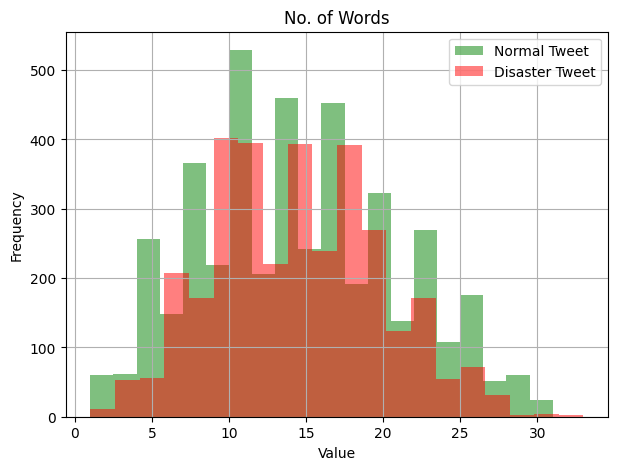

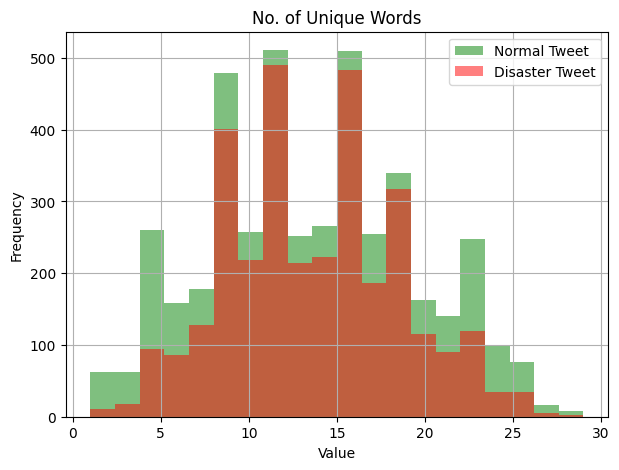

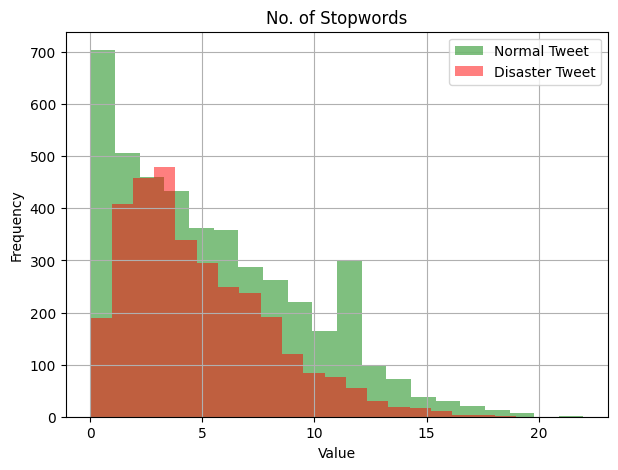

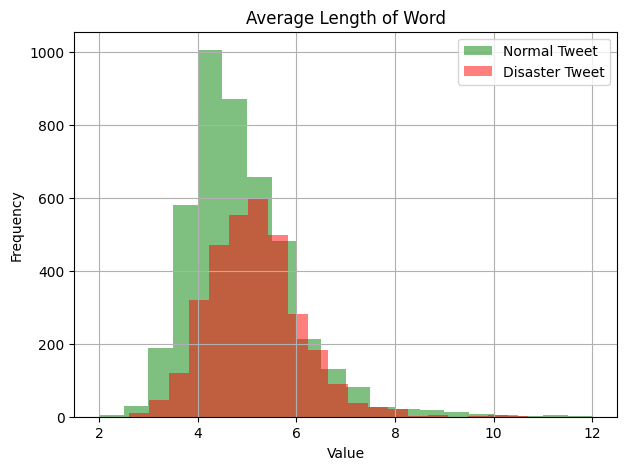

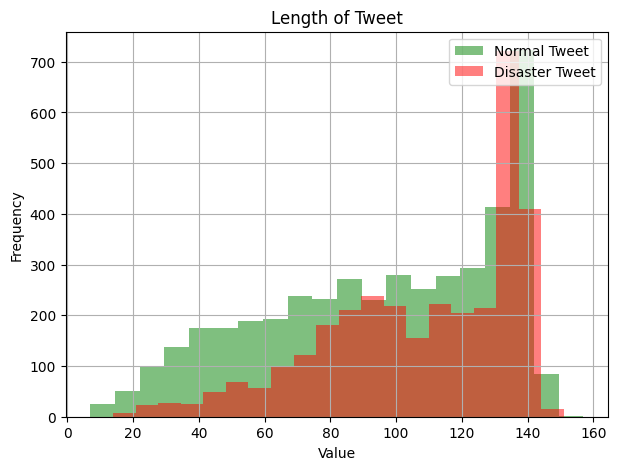

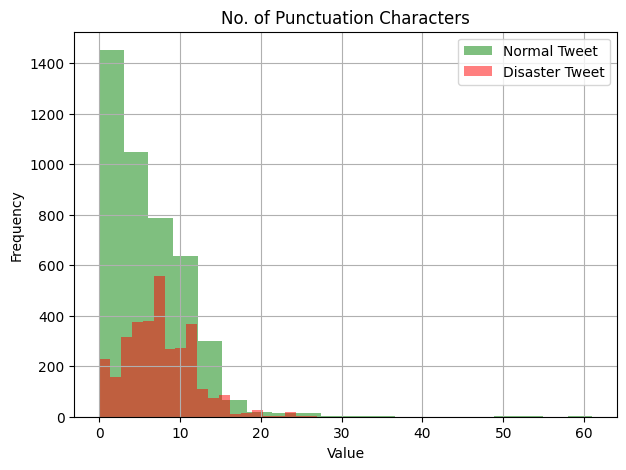

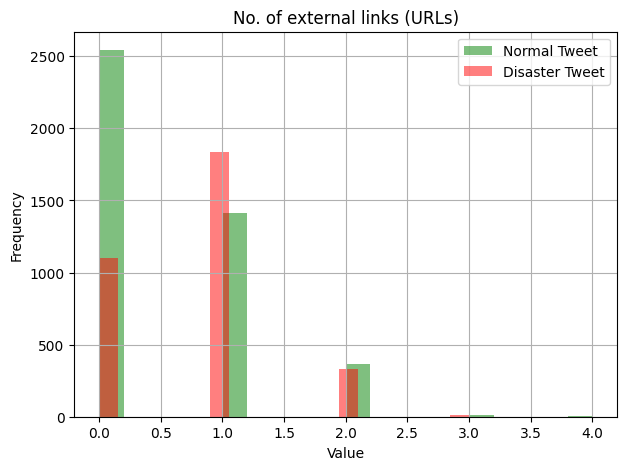

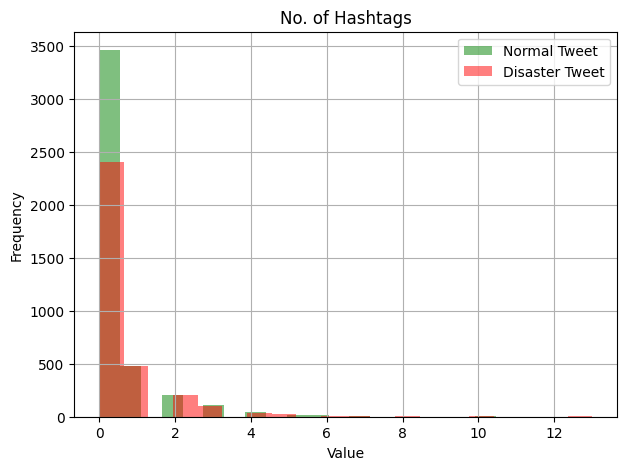

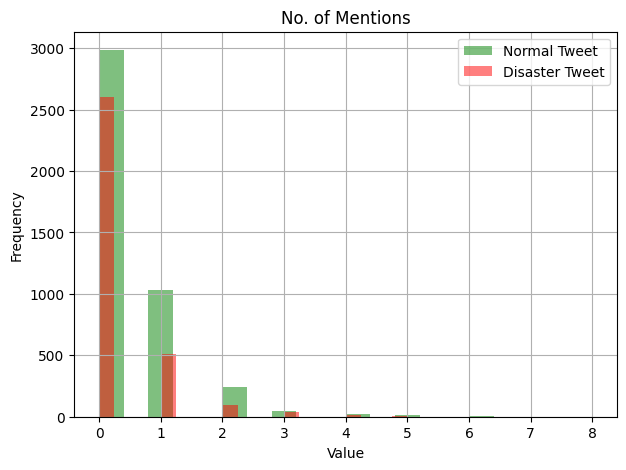

In [ ]:
# Defining text-based features for visualisation
numerical_features = [('word_count', 'No. of Words'), ('unique_word_count', 'No. of Unique Words'), ('stop_word_count', 'No. of Stopwords'),
            ('average_word_length', 'Average Length of Word'), ('text_length', 'Length of Tweet'), ('punctuation_count', 'No. of Punctuation Characters'),
            ('url_link_count', 'No. of external links (URLs)'), ('hashtag_count', 'No. of Hashtags'), ('mention_count', 'No. of Mentions')]

# Displaying each feature plot individually
for feature, title in numerical_features:
    plt.figure(figsize=(7, 5))

    # Plotting histogram for non-disaster tweets
    dataset[dataset['target'] == 0][feature].hist(bins=20, alpha=0.5, label='Normal Tweet', color='green')

    # Plotting histogram for disaster tweets
    dataset[dataset['target'] == 1][feature].hist(bins=20, alpha=0.5, label='Disaster Tweet', color='red')

    # Setting plot title and labels
    plt.title(title)
    plt.ylabel('Frequency')
    plt.xlabel('Value')
    plt.legend(loc='upper right')

    # Displaying the plot
    plt.show()
    print()

In [ ]:
# Defining the columns to be normalised, starting from the 5th column onward
normalised_features = list(dataset.columns[4:])

# Normalising each selected column using mean and standard deviation
for column in normalised_features:
    dataset[column] = (dataset[column] - dataset[column].mean()) / dataset[column].std()

# Displaying the normalised dataframe
dataset

,keyword,location,text,target,word_count,unique_word_count,stop_word_count,average_word_length,text_length,punctuation_count,url_link_count,hashtag_count,mention_count
id,,,,,,,,,,,,,
1,NaN,<NA>,Our Deeds are the Reason of this #earthquake M...,1,-0.214038,-0.093710,0.240620,-0.649600,-0.948377,-1.267041,-0.934019,0.507241,-0.501508
4,NaN,<NA>,Forest fire near La Ronge Sask. Canada,1,-1.208830,-1.202931,-1.340144,-0.553234,-1.866044,-1.267041,-0.934019,-0.404595,-0.501508
5,NaN,<NA>,All residents asked to 'shelter in place' are ...,1,1.278151,0.830641,1.557924,0.024962,0.946161,-0.833084,-0.934019,-0.404595,-0.501508
6,NaN,<NA>,"13,000 people receive #wildfires evacuation or...",1,-1.208830,-1.202931,-1.076683,2.048647,-1.066786,-1.050063,-0.934019,0.507241,-0.501508
7,NaN,<NA>,Just got sent this photo from Ruby #Alaska as ...,1,0.283358,0.276030,0.504081,-0.553234,-0.385936,-1.050063,-0.934019,1.419078,-0.501508
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10869,NaN,<NA>,Two giant cranes holding a bridge collapse int...,1,-0.711434,-0.648321,-0.813222,0.121328,-0.533947,-0.399128,0.572163,-0.404595,-0.501508
10870,NaN,<NA>,@aria_ahrary @TheTawniest The out of control w...,1,0.946553,0.460901,1.031002,0.121328,0.709344,-0.399128,-0.934019,-0.404595,2.300679
10871,NaN,<NA>,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,-1.208830,-1.202931,-0.549762,-1.805992,-1.066786,0.902741,0.572163,-0.404595,-0.501508


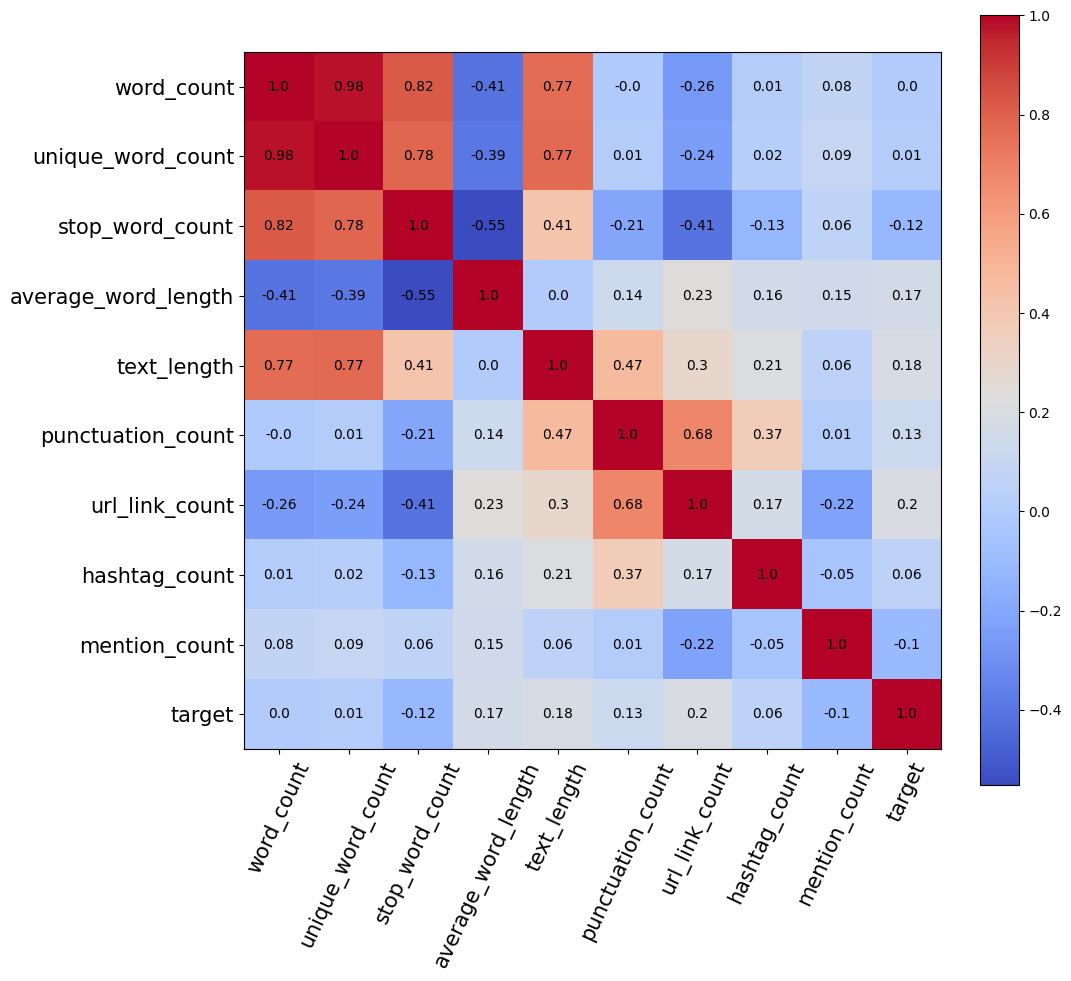

In [ ]:
def heat_map(columns, corr_matrix):
    # Getting the number of columns for defining figure size
    columns_len = len(columns)

    # Creating a figure and axis for the heatmap
    fig, ax = plt.subplots(figsize=(columns_len, columns_len))

    # Displaying the correlation matrix with a different color palette
    im = ax.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')

    # Adding a color bar to the right
    cbar = fig.colorbar(im, orientation='vertical', fraction=0.05, ax=ax)

    # Setting tick positions and labels for both axes
    ax.set_xticks(range(columns_len))
    ax.set_yticks(range(columns_len))
    ax.set_xticklabels(columns, rotation=65, fontsize=15)
    ax.set_yticklabels(columns, rotation=0, fontsize=15)

    # Looping over matrix to annotate each cell with its correlation value
    for i in range(columns_len):
        for j in range(columns_len):
            ax.text(j, i, round(corr_matrix[i, j], 2),
                    ha="center", va="center", color="black")

    # Displaying the heatmap
    plt.show()

def correlation_matrix(columns):
    # Getting the number of selected columns
    columns_count = len(columns)

    # Initialising an empty matrix for Pearson correlation coefficients
    correl_matrix = np.zeros((columns_count, columns_count))

    # Calculating the Pearson correlation for each pair of columns
    for i1, column1 in enumerate(columns):
        for i2, column2 in enumerate(columns):
            correl_matrix[i1][i2] = dataset[column1].corr(dataset[column2], method='pearson')

    return correl_matrix

# Defining the columns to include in the correlation matrix
columns = normalised_features + ['target']

# Calculating the Pearson correlation matrix
correl_matrix = correlation_matrix(columns)

# Drawing the heatmap for visualisation
heat_map(columns, correl_matrix)

# **Word Embeddings**

In [ ]:
def fasttext_path(embedding):
    embedding_path = {
        "crawl": "../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec",
    }
    return embedding_path.get(embedding)

In [ ]:
# Loading the FastText crawl embeddings
fasttext_crawl_word_embeddings = KeyedVectors.load_word2vec_format(fasttext_path('crawl'))

In [ ]:
# Extracting vocabulary from the given text data
def vocabulary(X):
    vocab = {}
    # Splitting each text into words
    texts = X.apply(lambda s: s.split()).values
    for text in texts:
        for word in text:
            try:
                # Incrementing count if word exists
                vocab[word] += 1
            except KeyError:
                # Initialising word count if not present
                vocab[word] = 1
    return vocab

# Checking the coverage of words in embeddings
def embeddings_coverage(X, embeddings):
    vocab = vocabulary(X)
    covered, oov = {}, {}
    n_covered, n_oov = 0, 0

    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]

    coverage_of_vocabulary = len(covered) / len(vocab)
    textual_coverage = n_covered / (n_covered + n_oov)
    out_of_vocabulary = sorted(oov.items(), key=operator.itemgetter(1), reverse=True)

    return out_of_vocabulary, coverage_of_vocabulary, textual_coverage

In [ ]:
# Checking the coverage of FastText embeddings on the dataset
oov, coverage_of_vocabulary, textual_coverage = embeddings_coverage(dataset['text'], fasttext_crawl_word_embeddings)

# Displaying the percentage of vocabulary and text covered by the embeddings
print(f'Crawl Embeddings cover {round(coverage_of_vocabulary*100, 2)}% of vocabulary and {round(textual_coverage*100, 2)}% of text')

Crawl Embeddings cover 51.52% of vocabulary and 81.84% of text


In [ ]:
# Removing URL links from the text
def removing_links(text: str):
    return re.sub(r'http\S+', ' ', text)

# Expanding shortened word forms in the text
def expanding_abbreviations(text: str):
    result = re.sub("won't", ' will not', text)
    result = re.sub("can't", ' can not', result)
    result = re.sub("n't", ' not', result)
    result = re.sub("'m", ' am', result)
    result = re.sub("'re", ' are', result)
    result = re.sub("'ve", ' have', result)
    result = re.sub("'ll", ' will', result)
    result = re.sub("'d", ' would', result)
    result = re.sub("'s", ' ', result)
    return result

# Removing stop words from the text
def erasing_stopwords(text: str):
    stop_words = stopwords.words("english")
    return ' '.join([w for w in text.split() if w not in stop_words])

# Applying full preprocessing pipeline on the text
def preprocessing(text):
    # Converting text to lowercase
    text = str(text).lower()
    # Removing URLs
    text = removing_links(text)
    # Expanding contractions
    text = expanding_abbreviations(text)
    # Removing non-alphabetic characters
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Removing stop words
    text = erasing_stopwords(text)
    # Removing extra spaces
    text = re.sub('\s+', ' ', text)
    return text

In [ ]:
# Applying the preprocessing function to the 'text' column
dataset['text'] = dataset['text'].apply(lambda x: preprocessing(x))

# Checking the coverage of FastText embeddings on the preprocessed text
oov, coverage_of_vocabulary, textual_coverage = embeddings_coverage(dataset['text'], fasttext_crawl_word_embeddings)

# Printing the coverage statistics
print(f'Crawl Embeddings cover {round(coverage_of_vocabulary*100, 2)}% of vocabulary and {round(textual_coverage*100, 2)}% of text')

Crawl Embeddings cover 77.83% of vocabulary and 93.75% of text


In [ ]:
# Filling missing keyword values with 'empty' and formatting them
def preprocessing_keywords(dataset):
    dataset['keyword'] = dataset['keyword'].fillna('empty')
    dataset['keyword'] = dataset['keyword'].apply(lambda x: x.replace('%20', ' '))
    return dataset['keyword']

# Applying preprocessing to the 'keyword' column
dataset['keyword'] = preprocessing_keywords(dataset)

### Splitting Dataset

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Splitting dataset into training and testing sets
training_features, testing_features, training_targets, testing_targets = train_test_split(
    dataset.drop(['target'], axis=1), dataset['target'], test_size=0.04, shuffle=True
)

In [ ]:
%%capture
# Loading pre-trained BERT model
bert = TFBertModel.from_pretrained('bert-large-uncased')

# Loading BERT tokeniser
tokenised_bert_tweets = AutoTokenizer.from_pretrained('bert-large-uncased')

# **LSTM**

In [ ]:
# Initialising and fitting tokeniser on text data
tweet_tokenising_lstm = Tokenizer()
tweet_tokenising_lstm.fit_on_texts(training_features['text'])

# Initialising and fitting tokeniser on keyword data
keyword_tokenising_lstm = Tokenizer()
keyword_tokenising_lstm.fit_on_texts(training_features['keyword'])

def processing_tweets_lstm(X):
    # Converting text data into sequences and applying padding
    seq = tweet_tokenising_lstm.texts_to_sequences(X['text'])
    pad_seq = pad_sequences(seq)

    # Converting keyword data into a matrix representation
    keywords_matrix = keyword_tokenising_lstm.texts_to_matrix(X['keyword'])

    # Extracting meta features and concatenating with keyword features
    meta_features = X.loc[:, 'word_count':]
    float_features = np.concatenate([keywords_matrix, meta_features], axis=1)

    return pad_seq, float_features

# Preparing inputs for training and testing sets
padded_sequence_training, floating_features_training = processing_tweets_lstm(training_features)
padded_sequence_testing, floating_features_testing = processing_tweets_lstm(testing_features)

# Printing the shapes of the processed training data
print(padded_sequence_training.shape)
print(floating_features_training.shape)

padded_sequence_training, floating_features_training

(7308, 25)

(7308, 240)


(array([[    0,     0,     0, ...,   509,   301,    63],
        [    0,     0,     0, ...,   451,    10,   498],
        [    0,     0,     0, ...,  6207,   638,   186],
        ...,
        [    0,     0,     0, ...,   346,   990,  3789],
        [    0,     0,     0, ...,     0,   706,  1927],
        [    0,     0,     0, ...,  2653, 15692, 15693]], dtype=int32),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.57216315,
         -0.40459537, -0.501508  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.57216315,
         -0.40459537, -0.501508  ],
        [ 0.        ,  1.        ,  0.        , ...,  0.57216315,
         -0.40459537, -0.501508  ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -0.93401876,
         -0.40459537, -0.501508  ],
        [ 0.        ,  0.        ,  0.        , ..., -0.93401876,
         -0.40459537, -0.501508  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.57216315,
         -0.40459537,  2.30067944]]))

In [ ]:
# Setting the embedding vector length using the FastText embeddings
tweet_embedding_length = len(fasttext_crawl_word_embeddings['word'])

# Setting the vocabulary size by adding 1 for padding
size_of_vocabulary = len(tweet_tokenising_lstm.word_index) + 1

# Getting the input sequence length from the padded training sequences
length_of_input_tweet = len(padded_sequence_training[0])

# Getting the number of float-based input features
length_of_input_floating_features = len(floating_features_training[0])

# Initialising an embedding matrix to store word embeddings for the vocabulary
embedding_matrix = np.zeros((size_of_vocabulary, tweet_embedding_length))
unknown_words = []

# Iterating through the vocabulary to map words to their FastText embeddings
for word, i in tweet_tokenising_lstm.word_index.items():
    try:
        embedding_vector = fasttext_crawl_word_embeddings[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        unknown_words.append(word)

# Printing the number of words that do not have a corresponding embedding
print(len(unknown_words))

3386


### **Building Model**

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tf.get_logger().setLevel('INFO')

class LSTM_model:
    def __init__(self):
        # Building the model during initialisation
        self._model = self._building_model()

    @property
    def model(self) -> tf.keras.Model:
        # Returning the compiled LSTM model
        return self._model

    def _building_model(self) -> tf.keras.Model:
        # Defining text input for processing sequences
        text_input = keras.Input(shape=(None,), name="text")

        # Embedding layer initialising with pre-trained embeddings and keeping non-trainable
        x = Embedding(input_dim=size_of_vocabulary, output_dim=tweet_embedding_length,
                      weights=[embedding_matrix], input_length=length_of_input_tweet, trainable=False)(text_input)
        # Applying dropout to prevent overfitting
        x = SpatialDropout1D(0.4)(x)
        # Adding LSTM layer with 32 units and returning sequences
        x = LSTM(32, return_sequences=True)(x)
        # Applying another dropout layer
        x = SpatialDropout1D(0.1)(x)
        # Adding another LSTM layer with 16 units
        text_features = LSTM(16)(x)

        # Defining input for numerical features
        float_features_input = keras.Input(shape=(length_of_input_floating_features,), name="float_features")

        # Passing numerical features through dense layers with Mish activation
        x = Dense(64, activation=tf.keras.layers.Activation(tfa.activations.mish))(float_features_input)
        x = Dense(8, activation=tf.keras.layers.Activation(tfa.activations.mish))(x)
        meta_features = Dense(2, activation=tf.keras.layers.Activation(tfa.activations.mish))(x)

        # Concatenating LSTM output and numerical features
        features = concatenate([text_features, meta_features], axis=1)
        # Applying dropout to reduce overfitting
        x = Dropout(0.2)(features)
        x = Dense(8, activation=tf.keras.layers.Activation(tfa.activations.mish))(x)
        x = Dense(4, activation=tf.keras.layers.Activation(tfa.activations.mish))(x)
        # Final output layer with sigmoid activation
        output = Dense(1, activation='sigmoid')(x)

        # Returning the complete model
        return keras.Model(inputs=[text_input, float_features_input], outputs=[output])

In [ ]:
model = LSTM_model().model
model.summary()

Model: "model"

__________________________________________________________________________________________________

 Layer (type)                Output Shape                 Param #   Connected to                  


 text (InputLayer)           [(None, None)]               0         []                            

                                                                                                  

 embedding (Embedding)       (None, None, 300)            4708200   ['text[0][0]']                

                                                                                                  

 spatial_dropout1d (Spatial  (None, None, 300)            0         ['embedding[0][0]']           

 Dropout1D)                                                                                       

                                                                                                  

 float_features (InputLayer  [(None, 240)]                0         []             

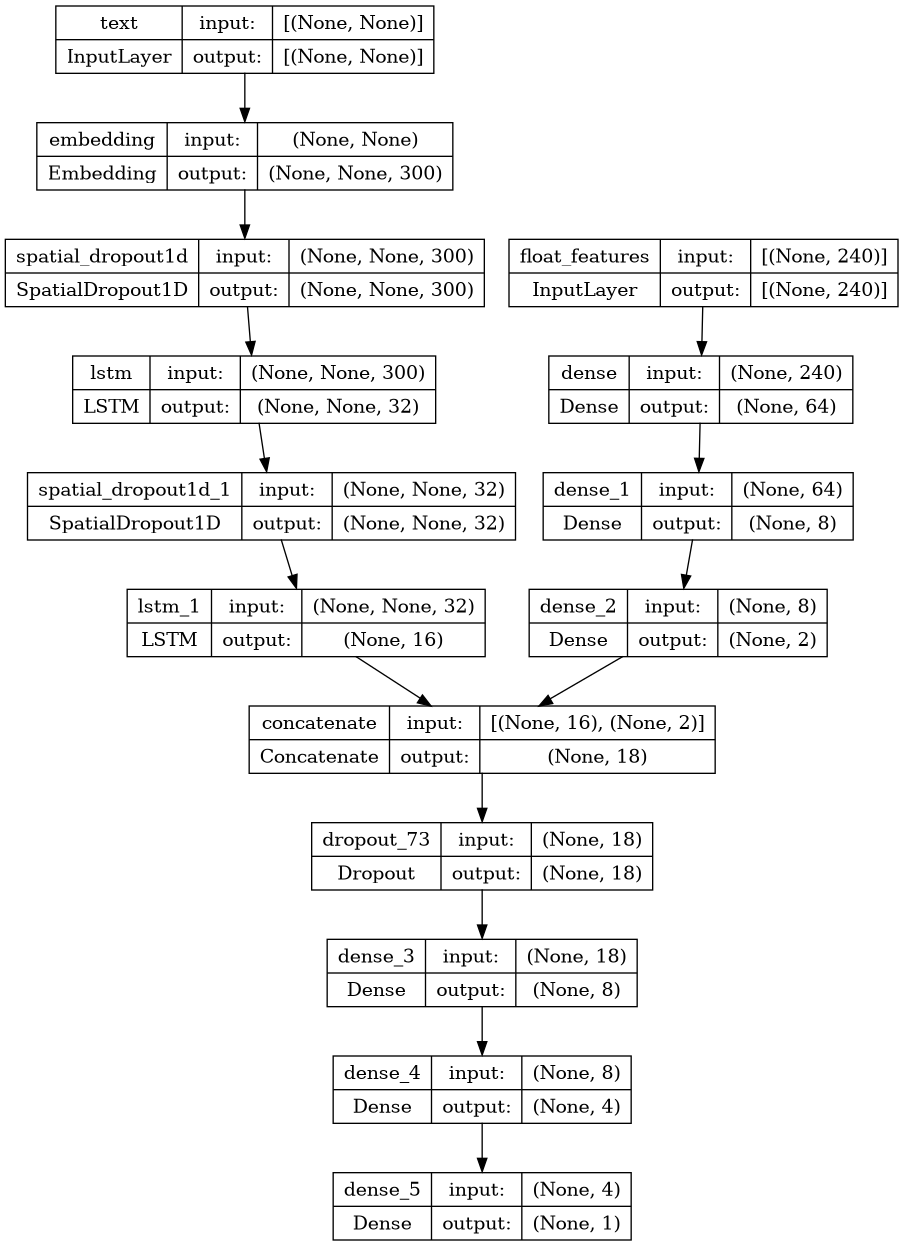

In [ ]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

## **Hyper-parameter Tuning**

In [ ]:
size_of_batch = 1
no_of_epochs = 20
ratio_of_train_to_val = 0.1
# Calculating the number of steps per epoch based on training data size
no_of_steps_per_epoch = int(len(padded_sequence_training) // size_of_batch * (1 - ratio_of_train_to_val))

def compiling_model(model, learning_rate, warmup_proportion):
    # Initialising Rectified Adam optimiser with Lookahead
    optimizer = tfa.optimizers.RectifiedAdam(
        learning_rate=learning_rate,
        total_steps=no_of_epochs * no_of_steps_per_epoch,
        warmup_proportion=warmup_proportion,
        min_lr=0.0000001,
    )
    optimizer = tfa.optimizers.Lookahead(optimizer)

    # Compiling the model with binary cross-entropy loss and evaluation metrics
    model.compile(optimizer=optimizer, loss='binary_crossentropy',
                  metrics=['accuracy',
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall'),
                           tfa.metrics.F1Score(num_classes=2, average='micro', threshold=0.5)]
                 )
    return model

def training_model(learning_rate, warmup_proportion):
    # Creating a new LSTM model instance
    model = LSTM_model().model
    compiling_model(model, learning_rate, warmup_proportion)

    # Defining a checkpoint path for saving the best model based on validation F1 score
    checkpoint_filepath = f'/content/checkpoints/lstm-model-checkpoint-{learning_rate}-{warmup_proportion}'
    save_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_f1_score',
        mode='max',
        save_best_only=True
    )

    # Training the model with specified parameters and saving history
    model_history = model.fit({'text': padded_sequence_training, 'float_features': floating_features_training},
                              training_targets,
                              epochs=no_of_epochs,
                              steps_per_epoch=no_of_steps_per_epoch,
                              validation_split=ratio_of_train_to_val,
                              callbacks=[save_callback],
                              verbose=1)
    return model_history, checkpoint_filepath

def searching_grid(params: list):
    results = []
    best_f1_score = 0
    best_checkpoint_filepath, best_model_history, best_params = None, None, None

    # Iterating through different hyperparameter configurations
    for model_params in params:
        learning_rate = model_params['learning_rate']
        warmup_proportion = model_params['warmup_proportion']
        model_history, checkpoint_filepath = training_model(learning_rate, warmup_proportion)

        # Extracting the best F1 score from the training history
        f1_score = max(model_history.history['val_f1_score'])
        if f1_score > best_f1_score:
            best_f1_score = f1_score
            best_checkpoint_filepath, best_model_history, best_params = checkpoint_filepath, model_history, model_params

        # Storing results for each configuration
        results.append({'params': model_params, 'model_history': model_history,
                        'checkpoint_filepath': checkpoint_filepath, 'f1_score': f1_score,
                        'best_epoch_index': np.argmax(model_history.history['val_f1_score'])})

    print(results)
    print(f'The best params were found: {best_params}')

    return results, best_checkpoint_filepath, best_model_history, best_params

# Running grid search with different learning rates and warmup proportions
lstm_all_results, lstm_checkpoint_filepath, lstm_model_history, lstm_best_params = searching_grid([
    {'learning_rate': 0.01, 'warmup_proportion': 0.1},
    {'learning_rate': 0.001, 'warmup_proportion': 0.2},
    {'learning_rate': 0.0005, 'warmup_proportion': 0.3},
    {'learning_rate': 0.0001, 'warmup_proportion': 0.3},
])

Epoch 1/20

6577/6577 [==============================] - 103s 14ms/step - loss: 0.5291 - accuracy: 0.7412 - precision: 0.7236 - recall: 0.6335 - f1_score: 0.6756 - val_loss: 0.5125 - val_accuracy: 0.7647 - val_precision: 0.6905 - val_recall: 0.8735 - val_f1_score: 0.7713

Epoch 2/20

6577/6577 [==============================] - 87s 13ms/step - loss: 0.4707 - accuracy: 0.7899 - precision: 0.8104 - recall: 0.6604 - f1_score: 0.7277 - val_loss: 0.4535 - val_accuracy: 0.8071 - val_precision: 0.8399 - val_recall: 0.7108 - val_f1_score: 0.7700

Epoch 3/20

6577/6577 [==============================] - 94s 14ms/step - loss: 0.4465 - accuracy: 0.8008 - precision: 0.7987 - recall: 0.7108 - f1_score: 0.7522 - val_loss: 0.4314 - val_accuracy: 0.8044 - val_precision: 0.8182 - val_recall: 0.7319 - val_f1_score: 0.7727

Epoch 4/20

6577/6577 [==============================] - 87s 13ms/step - loss: 0.4277 - accuracy: 0.8136 - precision: 0.8200 - recall: 0.7197 - f1_score: 0.7666 - val_loss: 0.4587 - v

## Comparison of the hyperparameters <a class="anchor"  id="h4-4"></a>

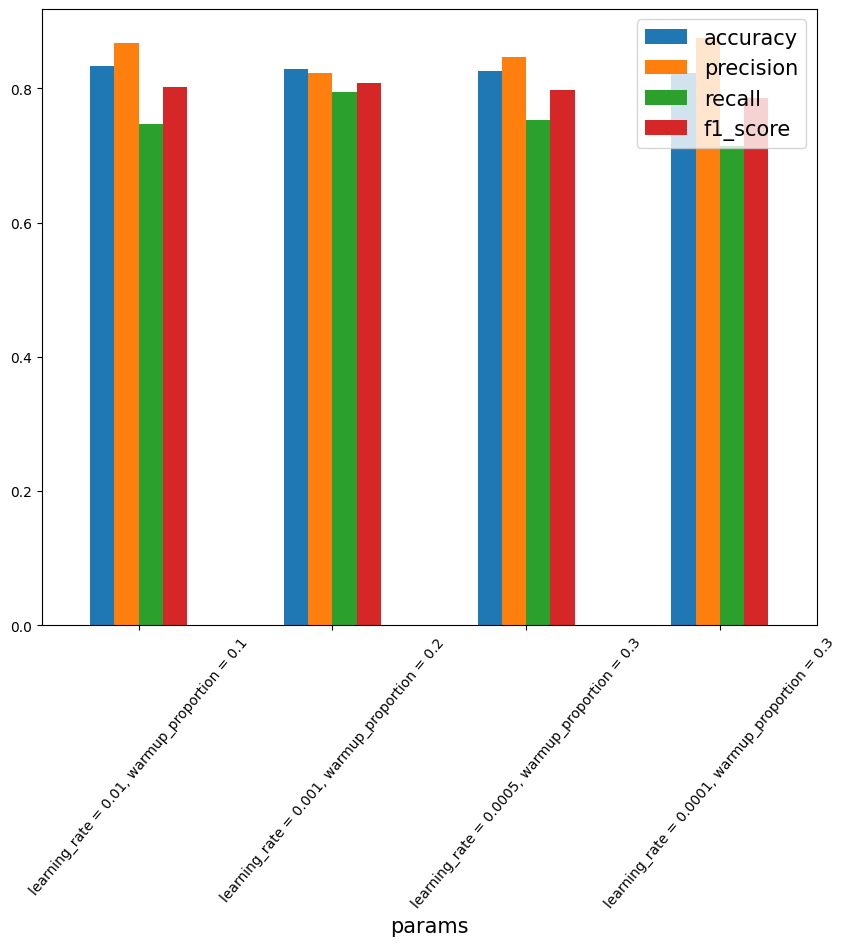

In [ ]:
# Creating a DataFrame to store hyperparameter configurations and their corresponding evaluation metrics
evaluation_metrics = pd.DataFrame([[
    f"learning_rate = {res['params']['learning_rate']}, warmup_proportion = {res['params']['warmup_proportion']}",
    res['model_history'].history['val_accuracy'][res['best_epoch_index']],
    res['model_history'].history['val_precision'][res['best_epoch_index']],
    res['model_history'].history['val_recall'][res['best_epoch_index']],
    res['model_history'].history['val_f1_score'][res['best_epoch_index']],
] for res in lstm_all_results], columns=['params', 'accuracy', 'precision', 'recall', 'f1_score'])

# Creating a bar plot to visualise model performance across different hyperparameters
fig, ax = plt.subplots()
evaluation_metrics.plot.bar(ax=ax, x='params', figsize=(10, 8), rot=50)
ax.set_xlabel('params', fontsize=15)
ax.legend(prop={'size': 15})

## Results analysis <a class="anchor"  id="h4-4"></a>

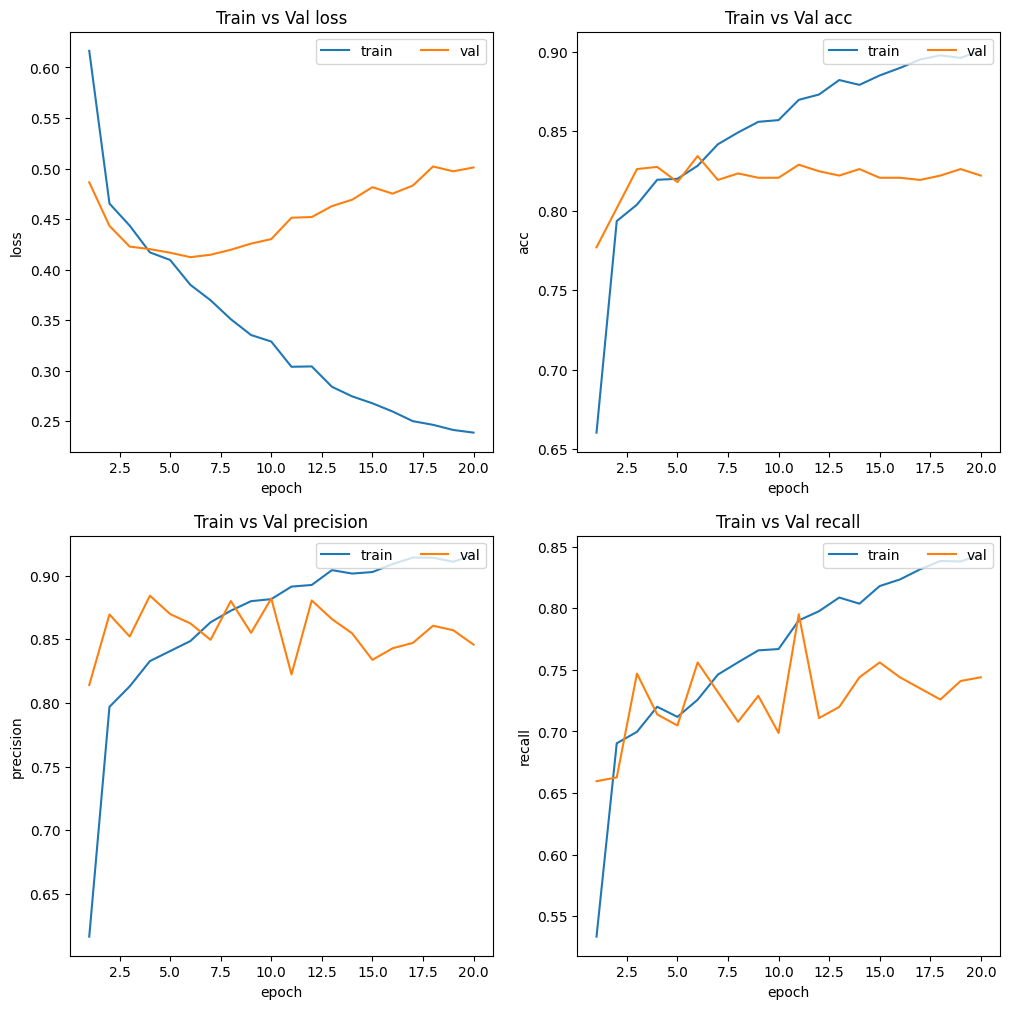

In [ ]:
# Defining a function to plot training and validation metrics over epochs
def graph(loss, val_loss, acc, val_acc, precision, val_precision, recall, val_recall):
    t = np.arange(1, len(loss) + 1, 1)

    # Creating a 2x2 grid of subplots for different metrics
    f, axs = plt.subplots(2, 2, figsize=(12, 12))
    plt.subplots_adjust(wspace=0.2)

    # Plotting training and validation loss
    axs[0,0].plot(t, loss)
    axs[0,0].plot(t, val_loss)
    axs[0,0].set_xlabel('epoch')
    axs[0,0].set_ylabel('loss')
    axs[0,0].set_title('Train vs Val loss')
    axs[0,0].legend(['train', 'val'], ncol=2, loc='upper right')

    # Plotting training and validation accuracy
    axs[0,1].plot(t, acc)
    axs[0,1].plot(t, val_acc)
    axs[0,1].set_xlabel('epoch')
    axs[0,1].set_ylabel('accuracy')
    axs[0,1].set_title('Train vs Val accuracy')
    axs[0,1].legend(['train', 'val'], ncol=2, loc='upper right')

    # Plotting training and validation precision
    axs[1,0].plot(t, precision)
    axs[1,0].plot(t, val_precision)
    axs[1,0].set_xlabel('epoch')
    axs[1,0].set_ylabel('precision')
    axs[1,0].set_title('Train vs Val precision')
    axs[1,0].legend(['train', 'val'], ncol=2, loc='upper right')

    # Plotting training and validation recall
    axs[1,1].plot(t, recall)
    axs[1,1].plot(t, val_recall)
    axs[1,1].set_xlabel('epoch')
    axs[1,1].set_ylabel('recall')
    axs[1,1].set_title('Train vs Val recall')
    axs[1,1].legend(['train', 'val'], ncol=2, loc='upper right')

    plt.show()

# Extracting training and validation metrics from model history
loss = lstm_model_history.history['loss']
acc = lstm_model_history.history['accuracy']
precision = lstm_model_history.history['precision']
recall = lstm_model_history.history['recall']
val_loss = lstm_model_history.history['val_loss']
val_acc = lstm_model_history.history['val_accuracy']
val_precision = lstm_model_history.history['val_precision']
val_recall = lstm_model_history.history['val_recall']

# Calling the function to visualise the metrics
graph(loss, val_loss, acc, val_acc, precision, val_precision, recall, val_recall)

In [ ]:
# Initialising the LSTM model
model = LSTM_model().model

# Loading the best model weights from the checkpoint
model.load_weights(lstm_checkpoint_filepath)

# Compiling the model using the best hyperparameters
compiling_model(model, lstm_best_params['learning_rate'], lstm_best_params['warmup_proportion'])

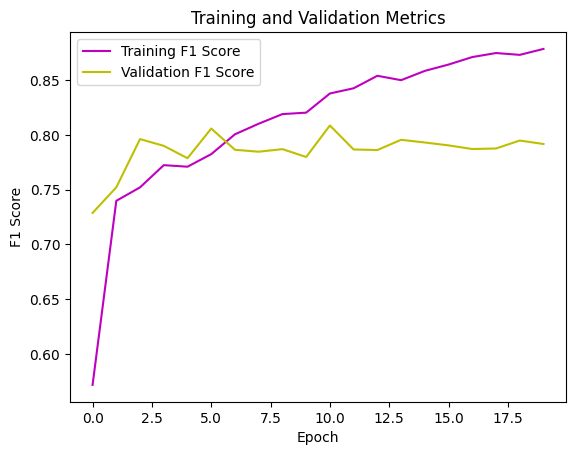

In [ ]:
# Extracting F1 scores for training and validation
f1_score = lstm_model_history.history['f1_score']
val_f1_score = lstm_model_history.history['val_f1_score']

plt.figure()

# Plotting training F1 score over epochs
plt.plot(lstm_model_history.epoch, f1_score, 'm', label='Training F1 Score')

# Plotting validation F1 score over epochs
plt.plot(lstm_model_history.epoch, val_f1_score, 'y', label='Validation F1 Score')
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [ ]:
# Applying the model on the test dataset
lstm_loss, lstm_acc, lstm_precision, lstm_recall, lstm_f1_score = model.evaluate(
    {'text': padded_sequence_testing, 'float_features': floating_features_testing}, testing_targets)

print(f"\n loss = {lstm_loss} \n acc = {lstm_acc} \n precision = {lstm_precision} \n recall = {lstm_recall} \n f1_score = {lstm_f1_score}")

10/10 [==============================] - 2s 5ms/step - loss: 0.4960 - accuracy: 0.8033 - precision: 0.7887 - recall: 0.7887 - f1_score: 0.7887



 loss = 0.49603456258773804 

 acc = 0.8032786846160889 

 precision = 0.7887324094772339 

 recall = 0.7887324094772339 

 f1_score = 0.7887324094772339


# **BERT**

In [ ]:
# Defining input sequence length for BERT
length_of_input_tweet = 30

# Initialising and fitting a tokeniser on keywords
keyword_tokenising_bert = Tokenizer()
keyword_tokenising_bert.fit_on_texts(training_features['keyword'])

def processing_tweets_bert(X):
    # Tokenising and padding text sequences using BERT tokeniser
    pad_seq = tokenised_bert_tweets(
        text=X['text'].tolist(),
        add_special_tokens=True,
        max_length=length_of_input_tweet,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )

    # Converting keywords into a matrix representation
    keywords_matrix = keyword_tokenising_bert.texts_to_matrix(X['keyword'])

    # Extracting numerical meta-features
    meta_features = X.loc[:, 'word_count':]

    # Combining keyword matrix with meta-features
    float_features = np.concatenate([keywords_matrix, meta_features], axis=1)

    return pad_seq, float_features

# Preparing input data for training and testing
padded_sequence_training, floating_features_training = processing_tweets_bert(training_features)
padded_sequence_testing, floating_features_testing = processing_tweets_bert(testing_features)

# Printing shapes of processed inputs
print(padded_sequence_training['input_ids'].shape)
print(padded_sequence_training['attention_mask'].shape)
print(floating_features_training.shape)

(7308, 30)

(7308, 30)

(7308, 240)


In [ ]:
# Defining the number of float-based features
length_of_input_floating_features = len(floating_features_training[0])

class BERT_model:
    def __init__(self):
        # Initialising the model
        self._model = self._building_model()

    @property
    def model(self) -> tf.keras.Model:
        return self._model

    def _building_model(self) -> tf.keras.Model:
        # Defining input layers for BERT tokenised sequences
        input_ids = keras.Input(shape=(length_of_input_tweet,), dtype=tf.int32, name='input_ids')
        attention_mask = keras.Input(shape=(length_of_input_tweet,), dtype=tf.int32, name='attention_mask')

        # Extracting word embeddings from the BERT model
        embeddings = bert(input_ids=input_ids, attention_mask=attention_mask)[0]

        # Applying dropout and dense layers to process embeddings
        x = SpatialDropout1D(0.1)(embeddings)
        x = Dense(1024, activation=tfa.activations.mish)(x)
        x = Dense(256, activation=tfa.activations.mish)(x)
        x = Dense(64, activation=tfa.activations.mish)(x)
        x = Dense(32, activation=tfa.activations.mish)(x)

        # Flattening text features for further processing
        text_features = Flatten()(x)

        # Defining input layer for additional float-based features
        float_features_input = keras.Input(shape=(length_of_input_floating_features,), name="float_features")

        # Processing float-based features through dense layers
        x = Dense(32, activation=tfa.activations.mish)(float_features_input)
        meta_features = Dense(8, activation=tfa.activations.mish)(x)

        # Concatenating text and numerical features
        features = concatenate([text_features, meta_features], axis=1)

        # Passing combined features through fully connected layers
        x = Dense(64, activation=tfa.activations.mish)(features)
        x = Dense(8, activation=tfa.activations.mish)(x)
        x = Dense(4, activation=tfa.activations.mish)(x)

        # Output layer for binary classification
        output = Dense(1, activation='sigmoid')(x)

        return keras.Model(inputs=[input_ids, attention_mask, float_features_input], outputs=[output])

In [ ]:
model = BERT_model().model
model.summary()

Model: "model_6"

__________________________________________________________________________________________________

 Layer (type)                Output Shape                 Param #   Connected to                  


 input_ids (InputLayer)      [(None, 30)]                 0         []                            

                                                                                                  

 attention_mask (InputLayer  [(None, 30)]                 0         []                            

 )                                                                                                

                                                                                                  

 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   3351418   ['input_ids[0][0]',           

 )                           ngAndCrossAttentions(last_   88         'attention_mask[0][0]']      

                             hidden_state=(None, 30, 10                          

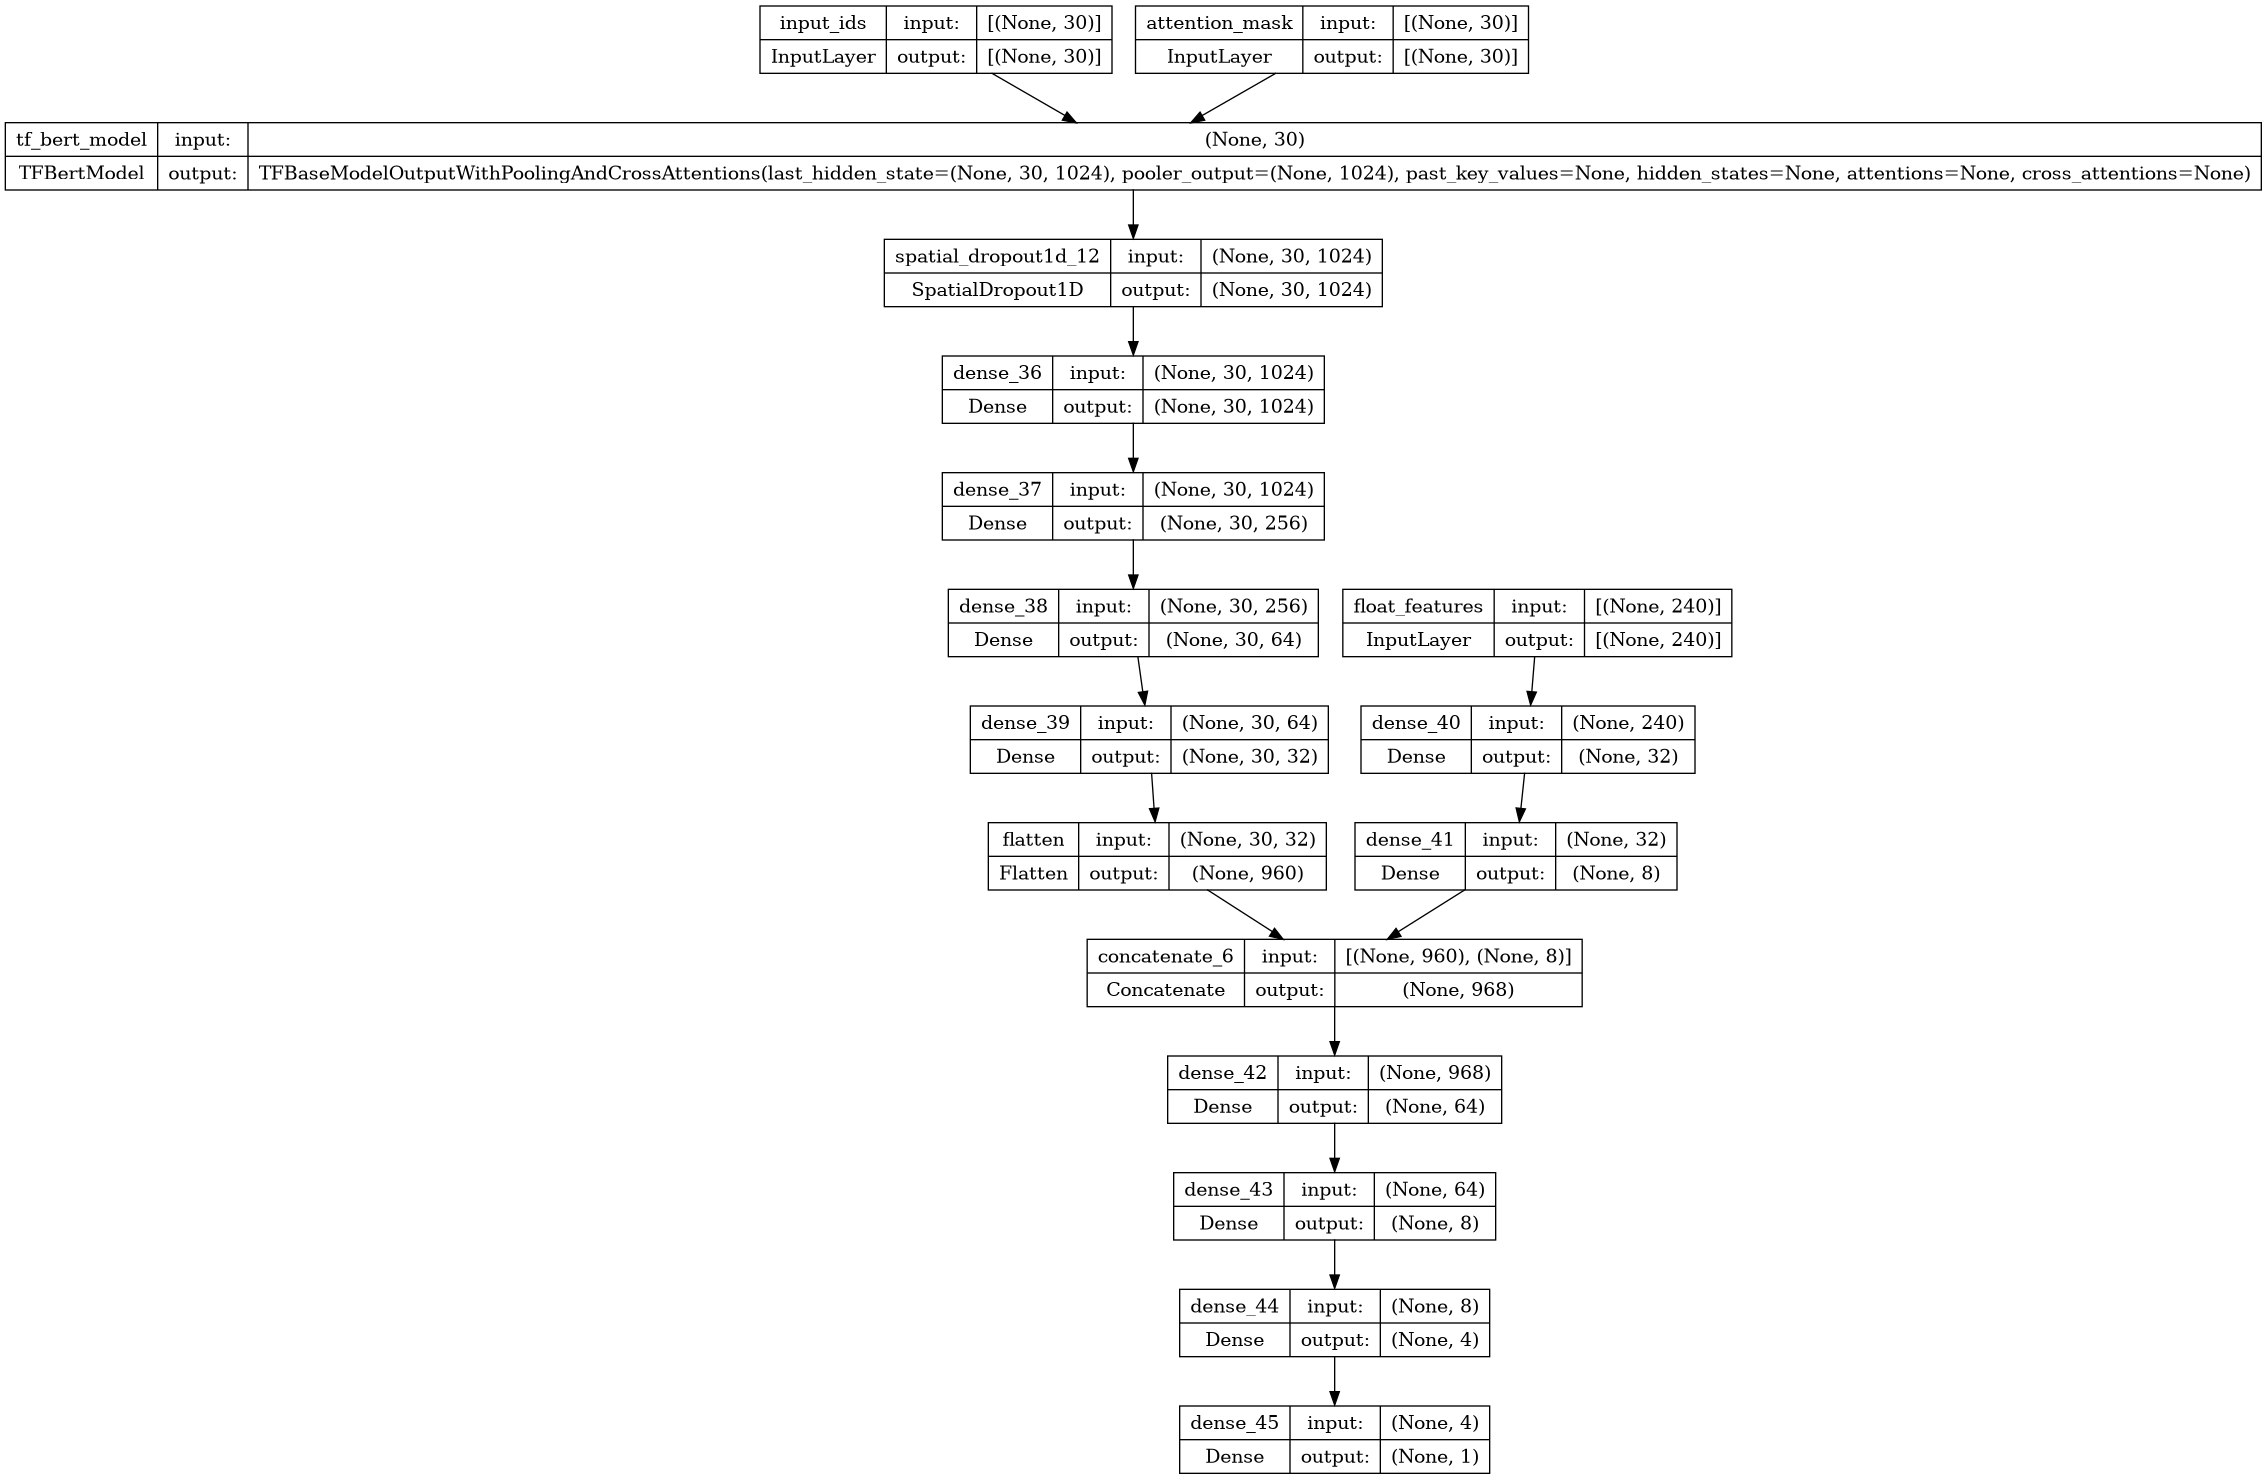

In [ ]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

### **Hyper-parameter Tuning**

In [ ]:
# Defining training hyperparameters
size_of_batch = 8
no_of_epochs = 20
ratio_of_train_to_val = 0.1
no_of_steps_per_epoch = int(len(padded_sequence_training['input_ids']) // size_of_batch * (1 - ratio_of_train_to_val))

def compiling_model(model, learning_rate, warmup_proportion):
    # Initialising optimiser with warmup and learning rate scheduling
    optimizer = tfa.optimizers.RectifiedAdam(
        learning_rate=learning_rate,
        total_steps=no_of_epochs * no_of_steps_per_epoch,
        warmup_proportion=warmup_proportion,
        min_lr=0.0000001,
    )
    optimizer = tfa.optimizers.Lookahead(optimizer)  # Enhancing optimisation stability

    # Compiling the model with loss and evaluation metrics
    model.compile(optimizer=optimizer, loss='binary_crossentropy',
                  metrics=['accuracy',
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall'),
                           tfa.metrics.F1Score(num_classes=2, average='micro', threshold=0.5)])
    return model

def training_model(learning_rate, warmup_proportion):
    # Initialising and compiling the BERT model
    model = BERT_model().model
    compiling_model(model, learning_rate, warmup_proportion)

    # Setting up model checkpointing to save the best-performing model
    checkpoint_filepath = f'/content/checkpoints/bert-model-checkpoint-{learning_rate}-{warmup_proportion}'
    save_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_f1_score',
        mode='max',
        save_best_only=True
    )

    # Training the model on tokenised text and additional features
    model_history = model.fit({'input_ids': padded_sequence_training['input_ids'],
                               'attention_mask': padded_sequence_training['attention_mask'],
                               'float_features': floating_features_training},
                              training_targets,
                              epochs=no_of_epochs,
                              steps_per_epoch=no_of_steps_per_epoch,
                              validation_split=ratio_of_train_to_val,
                              batch_size=size_of_batch,
                              callbacks=[save_callback])
    return model_history, checkpoint_filepath

def searching_grid(params: list):
    # Performing hyperparameter tuning using grid search
    results = []
    best_f1_score = 0
    best_checkpoint_filepath, best_model_history, best_params = None, None, None

    for model_params in params:
        learning_rate = model_params['learning_rate']
        warmup_proportion = model_params['warmup_proportion']

        # Training model with current hyperparameter set
        model_history, checkpoint_filepath = training_model(learning_rate, warmup_proportion)
        f1_score = max(model_history.history['val_f1_score'])

        # Updating the best model if a higher F1-score is found
        if f1_score > best_f1_score:
            best_f1_score = f1_score
            best_checkpoint_filepath, best_model_history, best_params = checkpoint_filepath, model_history, model_params

        # Storing results for comparison
        results.append({'params': model_params, 'model_history': model_history,
                        'checkpoint_filepath': checkpoint_filepath, 'f1_score': f1_score,
                        'best_epoch_index': np.argmax(model_history.history['val_f1_score'])})

    print(results)
    print(f'The best params were found: {best_params}')

    return results, best_checkpoint_filepath, best_model_history, best_params

# Running grid search on different hyperparameter combinations
bert_all_results, bert_checkpoint_filepath, bert_model_history, bert_best_params = searching_grid([
    {'learning_rate': 0.01, 'warmup_proportion': 0.1},
    {'learning_rate': 0.001, 'warmup_proportion': 0.2},
])

# Loading the best model checkpoint after training
model = BERT_model().model
model.load_weights(bert_checkpoint_filepath)

Epoch 1/20

821/821 [==============================] - 564s 515ms/step - loss: 0.6820 - accuracy: 0.5723 - precision: 0.4859 - recall: 0.1049 - f1_score: 0.1726 - val_loss: 0.6902 - val_accuracy: 0.5458 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00

Epoch 2/20

821/821 [==============================] - 311s 378ms/step - loss: 0.6887 - accuracy: 0.5740 - precision: 0.2500 - recall: 7.1659e-04 - f1_score: 0.0014 - val_loss: 0.6896 - val_accuracy: 0.5458 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00

Epoch 3/20

821/821 [==============================] - 310s 377ms/step - loss: 0.6819 - accuracy: 0.5758 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6920 - val_accuracy: 0.5458 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00

Epoch 4/20

821/821 [==============================] - 310s 377ms/step - loss: 0.6822 - accuracy: 0.5743 - precision: 0.0000e+00 - r

## Comparison of the hyperparameters <a class="anchor"  id="h5-4"></a>

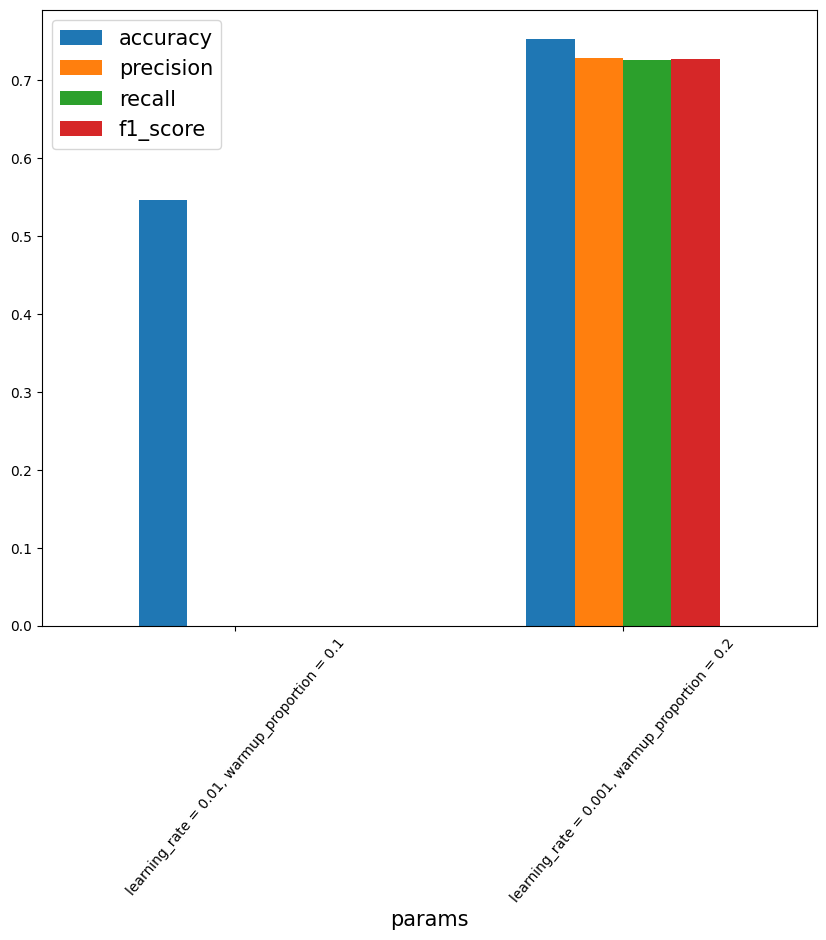

In [ ]:
# Creating a DataFrame to store validation metrics for different hyperparameter combinations
evaluation_metrics = pd.DataFrame([[
    f"learning_rate = {res['params']['learning_rate']}, warmup_proportion = {res['params']['warmup_proportion']}",
    res['model_history'].history['val_accuracy'][res['best_epoch_index']],
    res['model_history'].history['val_precision'][res['best_epoch_index']],
    res['model_history'].history['val_recall'][res['best_epoch_index']],
    res['model_history'].history['val_f1_score'][res['best_epoch_index']],
] for res in bert_all_results], columns=['params', 'accuracy', 'precision', 'recall', 'f1_score'])

# Plotting the performance of different hyperparameter configurations
fig, ax = plt.subplots()
evaluation_metrics.plot.bar(ax=ax, x='params', figsize=(10, 8), rot=50)

# Formatting the plot labels and legend
ax.set_xlabel('params', fontsize=15)
ax.legend(prop={'size': 15})

## Results analysis <a class="anchor"  id="h5-5"></a>

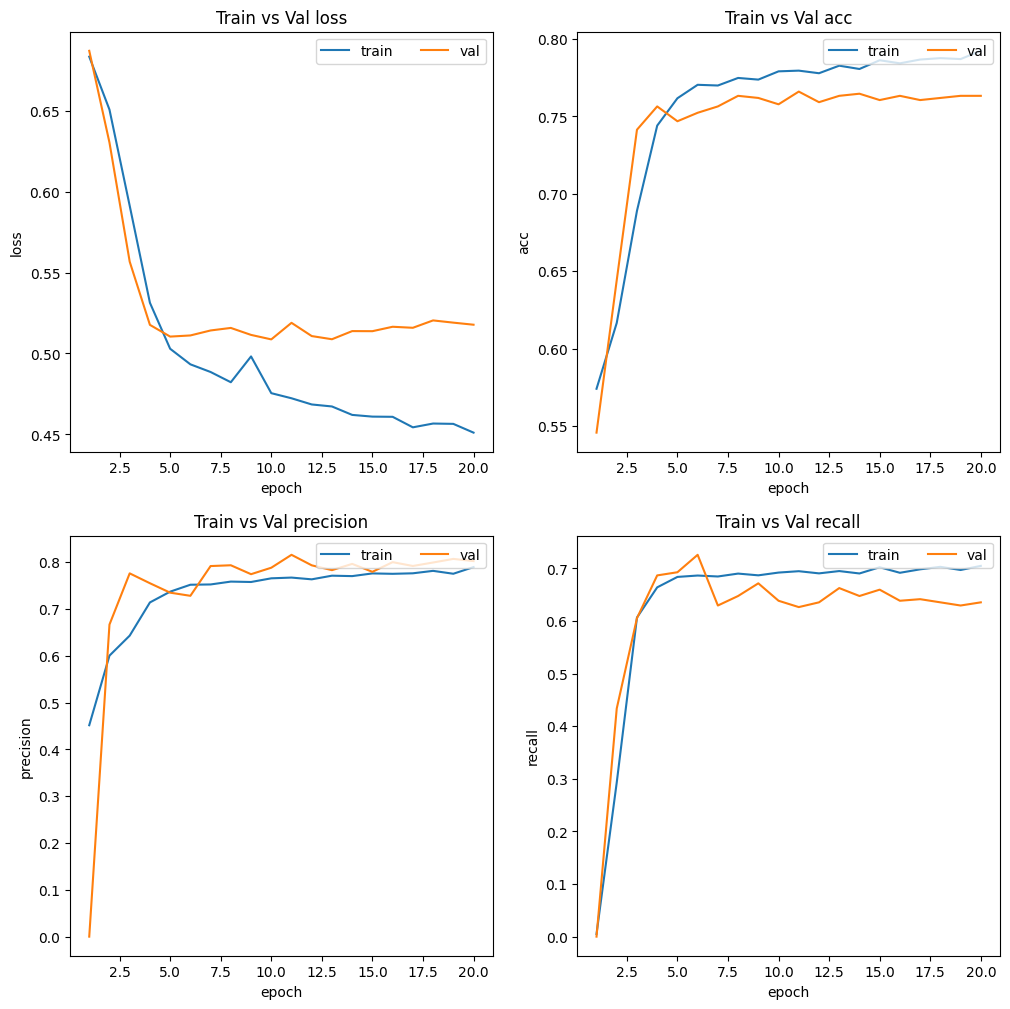

In [ ]:
# Function to plot training and validation metrics across epochs
def graph(loss, val_loss, acc, val_acc, precision, val_precision, recall, val_recall):
    t = np.arange(1, len(loss) + 1, 1)  # Creating epoch indices

    f, axs = plt.subplots(2, 2, figsize=(12,12))  # Creating a 2x2 grid of plots
    plt.subplots_adjust(wspace=0.2)  # Adjusting spacing between plots

    # Plotting training vs validation loss
    axs[0,0].plot(t, loss)
    axs[0,0].plot(t, val_loss)
    axs[0,0].set_xlabel('epoch')
    axs[0,0].set_ylabel('loss')
    axs[0,0].set_title('Train vs Val loss')
    axs[0,0].legend(['train','val'], ncol=2, loc='upper right')

    # Plotting training vs validation accuracy
    axs[0,1].plot(t, acc)
    axs[0,1].plot(t, val_acc)
    axs[0,1].set_xlabel('epoch')
    axs[0,1].set_ylabel('acc')
    axs[0,1].set_title('Train vs Val acc')
    axs[0,1].legend(['train','val'], ncol=2, loc='upper right')

    # Plotting training vs validation precision
    axs[1,0].plot(t, precision)
    axs[1,0].plot(t, val_precision)
    axs[1,0].set_xlabel('epoch')
    axs[1,0].set_ylabel('precision')
    axs[1,0].set_title('Train vs Val precision')
    axs[1,0].legend(['train','val'], ncol=2, loc='upper right')

    # Plotting training vs validation recall
    axs[1,1].plot(t, recall)
    axs[1,1].plot(t, val_recall)
    axs[1,1].set_xlabel('epoch')
    axs[1,1].set_ylabel('recall')
    axs[1,1].set_title('Train vs Val recall')
    axs[1,1].legend(['train','val'], ncol=2, loc='upper right')

    plt.show()  # Displaying the plots

# Extracting model training history
loss = bert_model_history.history['loss']
acc = bert_model_history.history['accuracy']
precision = bert_model_history.history['precision']
recall = bert_model_history.history['recall']
val_loss = bert_model_history.history['val_loss']
val_acc = bert_model_history.history['val_accuracy']
val_precision = bert_model_history.history['val_precision']
val_recall = bert_model_history.history['val_recall']

# Generating the plots
graph(loss, val_loss, acc, val_acc, precision, val_precision, recall, val_recall)

In [ ]:
# Initialising the BERT model
model = BERT_model().model

# Loading the best checkpoint weights from training
model.load_weights(bert_checkpoint_filepath)

# Compiling the model using the best hyperparameters found during tuning
compiling_model(model, bert_best_params['learning_rate'], bert_best_params['warmup_proportion'])

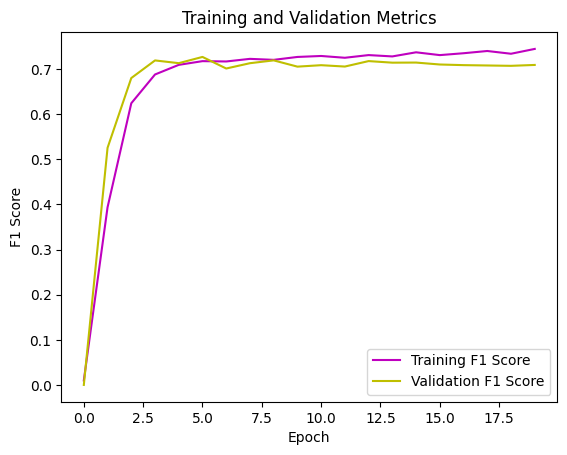

In [ ]:
# Extracting F1 scores from model training history
f1_score = bert_model_history.history['f1_score']
val_f1_score = bert_model_history.history['val_f1_score']

plt.figure()

# Plotting training and validation F1 scores across epochs
plt.plot(bert_model_history.epoch, f1_score, 'm', label='Training F1 Score')
plt.plot(bert_model_history.epoch, val_f1_score, 'y', label='Validation F1 Score')

plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [ ]:
# Applying the model on the testing data
bert_loss, bert_acc, bert_precision, bert_recall, bert_f1_score = model.evaluate(
    {'input_ids': padded_sequence_testing['input_ids'],
     'attention_mask': padded_sequence_testing['attention_mask'],
     'float_features': floating_features_testing},
    testing_targets
)

print(f"\n loss = {bert_loss} \n acc = {bert_acc} \n precision = {bert_precision} \n recall = {bert_recall} \n f1_score = {bert_f1_score}")

10/10 [==============================] - 17s 152ms/step - loss: 0.5290 - accuracy: 0.7508 - precision: 0.7200 - recall: 0.7606 - f1_score: 0.7397



 loss = 0.5290462970733643 

 acc = 0.7508196830749512 

 precision = 0.7200000286102295 

 recall = 0.7605633735656738 

 f1_score = 0.7397260069847107


# **Real-Data Implementation**

In [ ]:
# Loading the test dataset
real_world_posts = pd.read_csv("RealWorldPosts.csv")

# Extracting additional text-based features
real_world_posts = extracting_features_from_tweet(real_world_posts)

# Preprocessing the text and keyword columns
real_world_posts['text'] = real_world_posts['text'].apply(lambda x: preprocessing(x))
real_world_posts['keyword'] = preprocessing_keywords(real_world_posts)

# Selecting the best model based on F1-score performance
if bert_f1_score > lstm_f1_score:
    # Preparing inputs for BERT model
    padded_sequence_testing, floating_features_testing = processing_tweets_bert(real_world_posts)
    model = BERT_model().model
    model.load_weights(bert_checkpoint_filepath)
    compiling_model(model, bert_best_params['learning_rate'], bert_best_params['warmup_proportion'])

    # Making predictions using the BERT model
    predictions = model.predict({'input_ids': padded_sequence_testing['input_ids'],
                                 'attention_mask': padded_sequence_testing['attention_mask'],
                                 'float_features': floating_features_testing})
else:
    # Preparing inputs for LSTM model
    padded_sequence_testing, floating_features_testing = processing_tweets_lstm(real_world_posts)
    model = LSTM_model().model
    model.load_weights(lstm_checkpoint_filepath)
    compiling_model(model, lstm_best_params['learning_rate'], lstm_best_params['warmup_proportion'])

    # Making predictions using the LSTM model
    predictions = model.predict({'text': padded_sequence_testing, 'float_features': floating_features_testing})

# Assigning predictions as binary labels
real_world_posts['target'] = np.round(predictions).astype('int')

# Dislaying my predictions
prediction_as_disaster_or_normal = real_world_posts[["id", "target"]].set_index("id")
prediction_as_disaster_or_normal

102/102 [==============================] - 1s 3ms/step


,target
id,
0,1
2,1
3,1
9,1
11,1
...,...
10861,1
10865,1
10868,1
